In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/customer-clustering/segmentation data.csv
/kaggle/input/customer-clustering/segmentation data legend.xlsx


<h2>LOADING LIBRARIES/DATA</h2>

In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import time
import itertools
from scipy import stats

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
#!pip install -U seaborn 
import seaborn as sns

from sklearn.preprocessing import FunctionTransformer, MinMaxScaler, StandardScaler, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, make_scorer
from sklearn.exceptions import ConvergenceWarning
from sklearn.decomposition import PCA

In [3]:
train = pd.read_csv('/kaggle/input/customer-clustering/segmentation data.csv')
train.head()

,ID,Sex,Marital status,Age,Education,Income,Occupation,Settlement size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


According to the data legend the dataset has the following features:
<ul>
    <li><strong>ID</strong>: Shows a unique identificator of a customer.</li>
    <li><strong>Sex</strong>: Biological sex (gender) of a customer. In this dataset there are only 2 different options (0 = male, 1 = female). </li>
    <li><strong>Marital Status</strong>: Marital status of a customer (0 = single, 1 = non-single i.e. divorced/separated/married/widowed).</li>
    <li><strong>Age</strong>: The age of the customer in years, calculated as current year minus the year of birth of the customer (values between 18 and 76).</li>
    <li><strong>Education</strong>: Level of education of the customer (0 = other/unknown, 1 = high school, 2 = university, 3 = graduate school). </li>
    <li><strong>Income</strong>: Self-reported annual income in US dollars of the customer.</li>
    <li><strong>Occupation</strong>: Category of occupation of the customer (0 = unemployed/unskilled, 1 = 
skilled employee/official, 2 = management/self-employed/highly qualified employee/officer).</li>
    <li><strong>Settlement size</strong>: The size of the city that the customer lives in (0 = small city, 1 = mid-sized city, 2 = big city).</li>
</ul>
*Note: since no other indication of gender identity is stated we will refer to the sex options simply as "female" and "male".*

We define dictionaries to convert categorical features in more recognizable categories, which we'll use later:

In [4]:
Sex_dict = {0 : 'Male', 1 : 'Female'}
Marital_Status_dict = {0 : 'Single', 1 : 'Non-Single'}
Education_dict = {0 : 'Unknown', 1 : 'High school', 2 : 'Uni', 3 : 'Grad'}
Occupation_dict = {0 : 'no/Unskilled', 1 : 'Skilled', 2 : 'Qualified'}
Settlement_Size_dict = {0 : 'Small' , 1 : 'Mid', 2 : 'Big'}

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   ID               2000 non-null   int64
 1   Sex              2000 non-null   int64
 2   Marital status   2000 non-null   int64
 3   Age              2000 non-null   int64
 4   Education        2000 non-null   int64
 5   Income           2000 non-null   int64
 6   Occupation       2000 non-null   int64
 7   Settlement size  2000 non-null   int64
dtypes: int64(8)
memory usage: 125.1 KB


ID is defined as an unique identifier, if that's the case we'll use it as the index of the dataset:

In [6]:
if train['ID'].is_unique:
    train.set_index('ID', inplace = True)
    print('ID used as index')

ID used as index


We label the different features as categorical (less than 10 unique values) and numerical features:

In [7]:
categorical_feats = list(train.columns[train.nunique() < 10])
numerical_feats = list(set(train.columns) - set(categorical_feats))
print('CATEGORICAL FEATURES: ', categorical_feats)
print('NUMERICAL FEATURES: ', numerical_feats)

CATEGORICAL FEATURES:  ['Sex', 'Marital status', 'Education', 'Occupation', 'Settlement size']
NUMERICAL FEATURES:  ['Age', 'Income']


<h2>EDA</h2>

<h3>Missing values</h3>

We double check the absence of missing values (as suggested by the dataset info):

In [8]:
def check_nan(df):
    df_name = [x for x in globals() if globals()[x] is df][0]
    nan_vals = (100 * df.isnull().sum() / len(df))
    nan_Series = pd.Series(nan_vals, name = f'{df_name} nan pct')
    return nan_Series.sort_values(ascending = True)

check_nan(train)

Sex                0.0
Marital status     0.0
Age                0.0
Education          0.0
Income             0.0
Occupation         0.0
Settlement size    0.0
Name: train nan pct, dtype: float64

No missing values are detected.

<h3>Univariate analysis</h3>

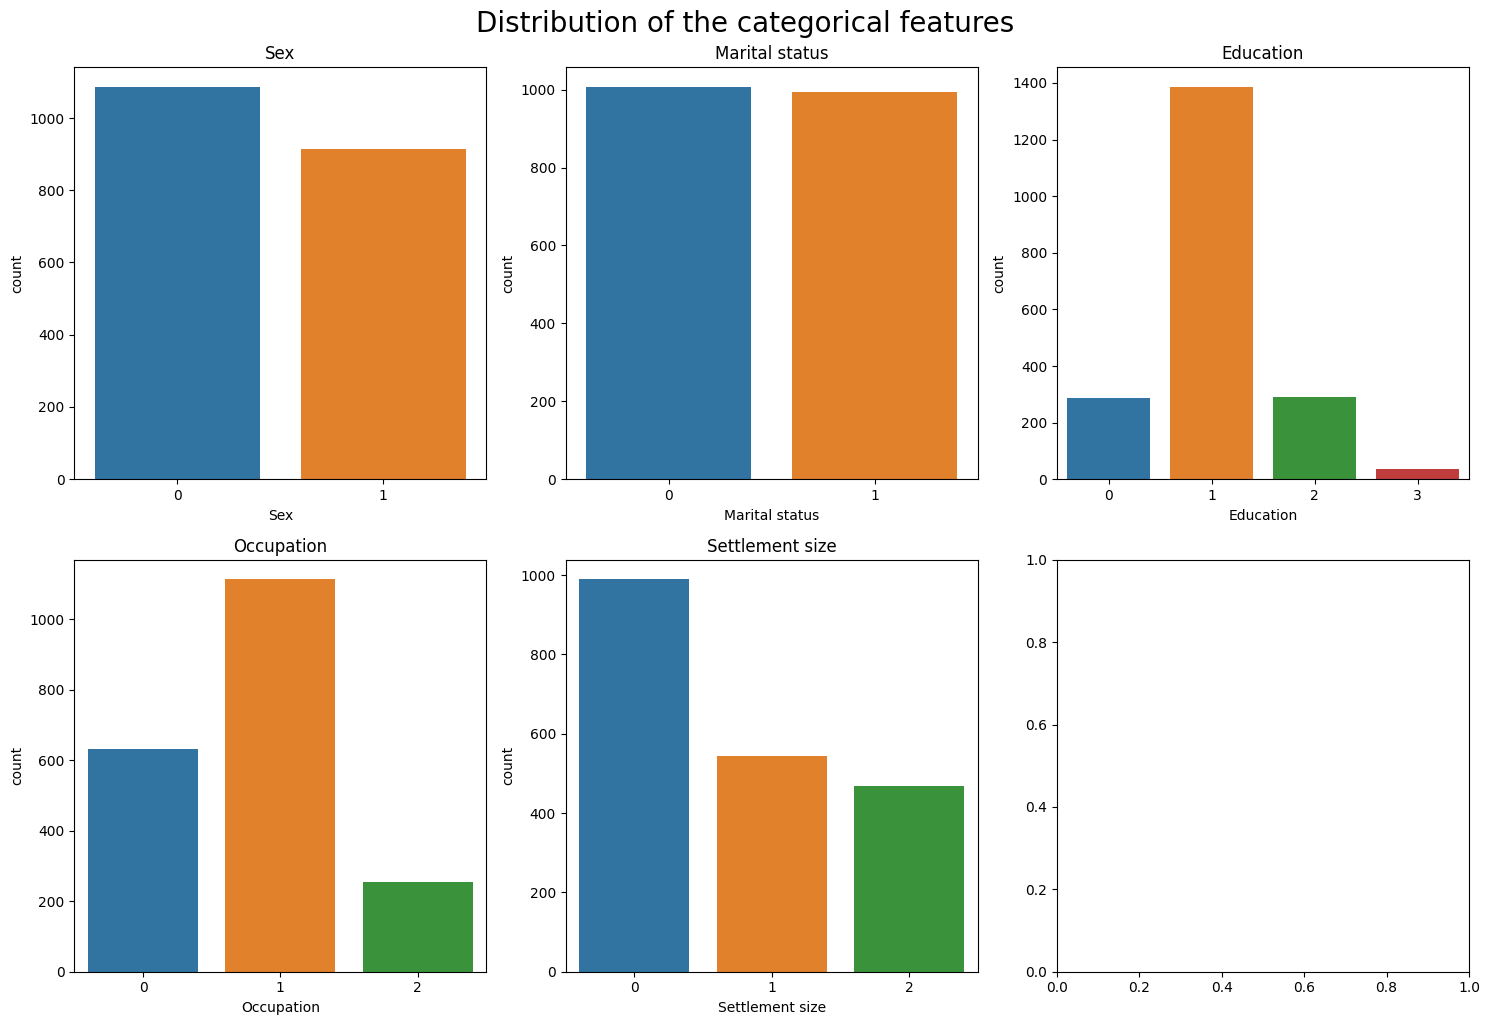

In [9]:
def plot_categorical(df, categorical_feats):
    rows = int(np.ceil(len(categorical_feats) / 3.))
    _, axes = plt.subplots(rows, 3, figsize = (15, 10))
    for feat, ax in zip(categorical_feats, axes.ravel()):
        sns.countplot(data = df, x = feat, ax = ax)
        ax.set_title(feat)
    plt.tight_layout()
    plt.suptitle('Distribution of the categorical features', fontsize = 20, y = 1.02)
    plt.show()
    
plot_categorical(train, categorical_feats)

**Outtakes**:
<ul>
    <li>Biological sex is (roughly) uniformely distributed as expected, Marital Status is split evenly between single and non-single.</li>
    <li>The Education level is dominated by the high school value, graduate school is a slim fraction that could be merged with university.</li>
    <li>The main occupation is skilled employee/official, followed by unemployed/unskilled.</li>
    <li>Most samples from the survey come from small cities.</li>
</ul>

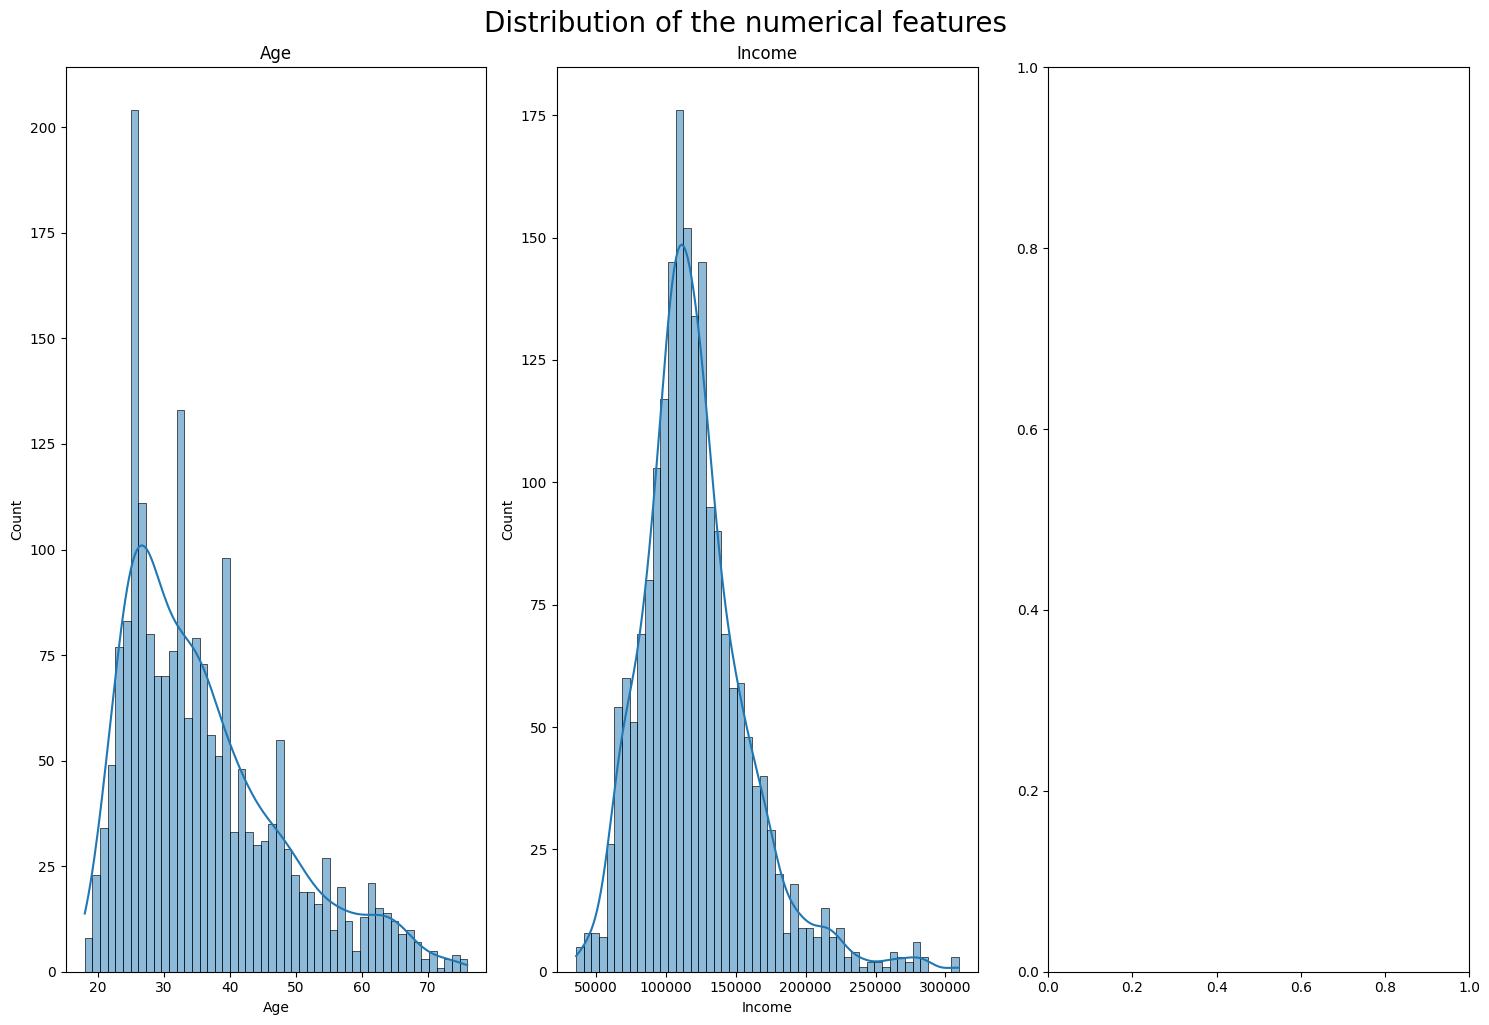

In [10]:
def plot_hist(df, feats):
    rows = int(np.ceil(len(feats) / 3.))
    _, axes = plt.subplots(rows, 3, figsize = (15, 10))
    for feat, ax in zip(feats, axes.ravel()):
        sns.histplot(data = df, x = feat, bins = 50, kde = True, ax = ax)
        ax.set_title(feat)
    plt.tight_layout()
    plt.suptitle('Distribution of the numerical features', fontsize = 20, y = 1.02)
    plt.show()

plot_hist(train, numerical_feats)

**Outtakes**:
<ul>
    <li>The <i>Age</i> feature has a peak at around 25 years and it's right skewed.</li>
    <li>The <i>Income</i> feature has a peak at around 120000, even though it's more symmetrical than the <i>Age</i> right skewness is still recognizable.</li>
</ul>

<h3>Multivariate analysis</h3>

We study the relation between categorical and numerical features: 

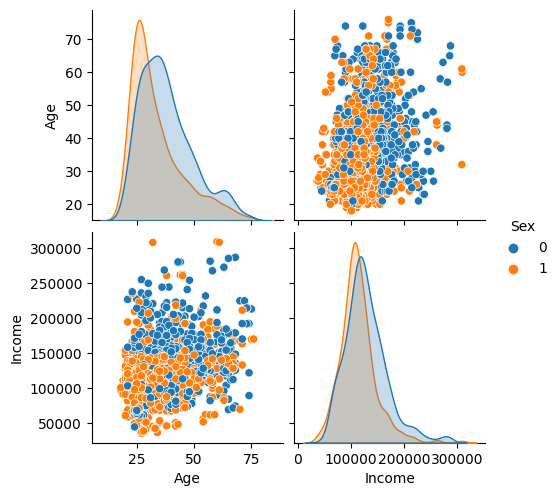

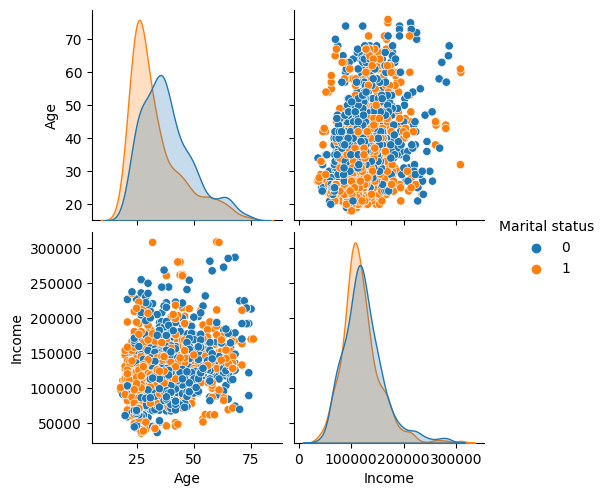

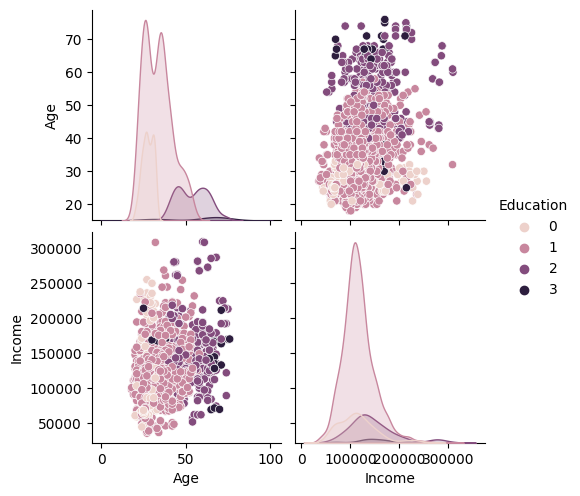

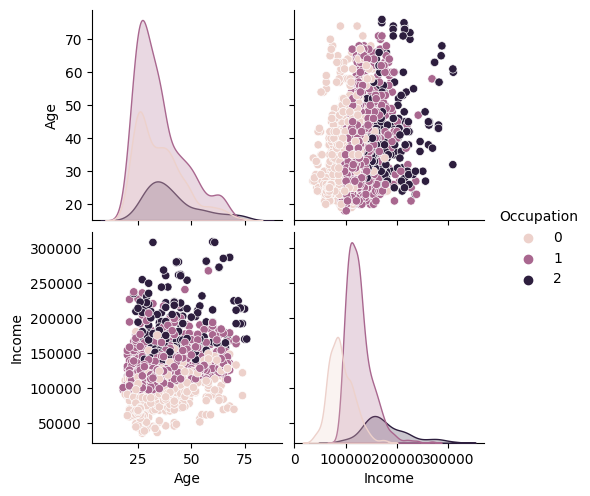

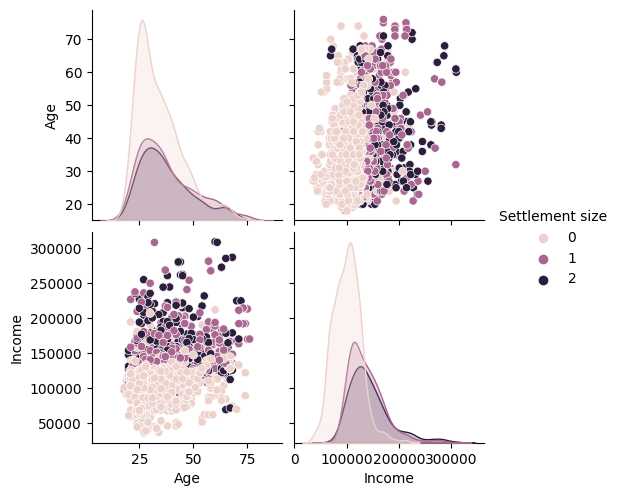

In [11]:
for feat in categorical_feats:
    sns.pairplot(train, vars = numerical_feats, hue = feat)

**Outtakes**:
<ul>
    <li>Males are generally older and have a slightly higher income than females.</li>
    <li>Single are generally older than non-single people.</li>
    <li>Older people tipically have an higher education, on the other hand there is not a strong correlation between education level and income.</li>
    <li>As expected the higher is the occupation skill leve the larger the income.</li>
    <li>There isn't strong correlation between age and settlement size, people with higher income tend to live in big cities. </li>
</ul>

<h2>MODELLING</h2>

We perform modelling on all features defining different combination of:
<ul>
    <li>Preprocessing: building pipeline for log-transforming the numerical features to correct the skewness, standard and min-max scaling to uniform the range of all feature whih is a crucial step in clustering models.</li>
    <li>Models: we try both KMeans and DBSCAN.</li>
</ul>

In [12]:
#LogTransformer = FunctionTransformer(np.log1p)
LogTransformer = FunctionTransformer(np.log1p)

pipeline_scaler = Pipeline([
    ('scaler', StandardScaler())
])

pipeline_MinMax = Pipeline([
    ('minmax', MinMaxScaler())
])
pipeline_log = ColumnTransformer([
    ('log', LogTransformer, numerical_feats)
], verbose_feature_names_out = False, remainder = 'passthrough')
pipeline_log.set_output(transform = 'pandas')

pipeline_base = Pipeline([
    ('scaler', pipeline_scaler)])

pipeline_NormScale = Pipeline([
    ('log', pipeline_log),
    ('scaler', pipeline_scaler)
])

pipeline_NormMinMax = Pipeline([
    ('log', pipeline_log),
    ('minmax', pipeline_MinMax)
])

preprocessor_dict = {
    'Scale' : pipeline_scaler,
    'MinMax' : pipeline_MinMax,
    'NormScale' : pipeline_NormScale,
    'NormMinMax' : pipeline_NormMinMax
}
model_dict = {'KMEANS' : KMeans(), 'DBSCAN' : DBSCAN()}
grid_params = {'KMEANS' : {'n_clusters' : range(2, 21), 'random_state' : range(0, 21)}, 
              'DBSCAN' : {'eps' : np.arange(0.01, 0.11, 0.01), 'min_samples' : range(3,8)}}

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_function_transformer.py:343: UserWarning: With transform="pandas", `func` should return a DataFrame to follow the set_output API.
  warnings.warn(


In [13]:
estimator_list = [x[0] + '-' + x[1] for x in itertools.product(preprocessor_dict.keys(), model_dict.keys())]
best_results = pd.DataFrame({'Estimator': estimator_list, 'Best Score': np.zeros(len(estimator_list)), 'Training Time': np.zeros(len(estimator_list)),
                          'Best Params': [None for _ in range(len(estimator_list))]})
best_results.set_index('Estimator', inplace = True)
scores_dict = {}

for estimator in estimator_list:
    print(estimator)
    
    prep_key, model_key = estimator.split('-')
    best_score = - 1
    best_params = None
    keys, values = zip(*grid_params[model_key].items())
    permutations_dicts = [dict(zip(keys, v)) for v in itertools.product(*values)]

    result_dict = dict.fromkeys(list(grid_params[model_key].keys()) + ['score'], [])
    start = time.time()
    for param_dict in permutations_dicts:
        result_dict.update({key: result_dict[key] + [param_dict[key]] if key in param_dict.keys() else result_dict[key] for key in result_dict.keys()}) 
        with warnings.catch_warnings(): 
            warnings.simplefilter('ignore', category = ConvergenceWarning)

            model_dict[model_key].set_params(**param_dict)
            X = preprocessor_dict[prep_key].fit_transform(train)
            y_pred = model_dict[model_key].fit_predict(X)
            try:   
                score = silhouette_score(X, y_pred)
            except ValueError:
                score = - 1

            if score > best_score:
                best_score = score
                best_params = param_dict
            result_dict['score'].append(score)
    stop = time.time()
    best_results.loc[estimator,'Best Score'] = best_score
    best_results.loc[estimator,'Training Time'] = np.round((stop - start), 2)
    best_results.loc[estimator,'Best Params'] = str(best_params)

    scores_dict[estimator] = result_dict
    print('Estimator:', estimator)
    print('Training time (s):', best_results.loc[estimator,'Training Time'])
    print('')

Scale-KMEANS
Estimator: Scale-KMEANS
Training time (s): 44.42

Scale-DBSCAN
Estimator: Scale-DBSCAN
Training time (s): 2.79

MinMax-KMEANS
Estimator: MinMax-KMEANS
Training time (s): 38.42

MinMax-DBSCAN
Estimator: MinMax-DBSCAN
Training time (s): 3.8

NormScale-KMEANS
Estimator: NormScale-KMEANS
Training time (s): 45.4

NormScale-DBSCAN
Estimator: NormScale-DBSCAN
Training time (s): 2.69

NormMinMax-KMEANS
Estimator: NormMinMax-KMEANS
Training time (s): 38.78

NormMinMax-DBSCAN
Estimator: NormMinMax-DBSCAN
Training time (s): 3.92



In [14]:
best_results

,Best Score,Training Time,Best Params
Estimator,,,
Scale-KMEANS,0.379965,44.42,"{'n_clusters': 20, 'random_state': 14}"
Scale-DBSCAN,-0.072659,2.79,"{'eps': 0.04, 'min_samples': 5}"
MinMax-KMEANS,0.507029,38.42,"{'n_clusters': 20, 'random_state': 8}"
MinMax-DBSCAN,0.578494,3.80,"{'eps': 0.09999999999999999, 'min_samples': 3}"
NormScale-KMEANS,0.352744,45.40,"{'n_clusters': 20, 'random_state': 17}"
NormScale-DBSCAN,-0.044520,2.69,"{'eps': 0.060000000000000005, 'min_samples': 5}"
NormMinMax-KMEANS,0.493603,38.78,"{'n_clusters': 19, 'random_state': 15}"
NormMinMax-DBSCAN,0.528779,3.92,"{'eps': 0.09999999999999999, 'min_samples': 3}"


**Outtakes**:
<ul>
    <li>MinMax scaling proves to be a large improvement over standard scaling.</li>
    <li>Apparently normalization procedures don't benefit clusters identification.</li>
    <li>DBSCAN seems to outperform KMeans.</li>
</ul>
These results however don't take into account our requirements of interpretability: the hughest score for KMeans corresponds to 20 clusters, which seems an unusually large number to categorize customers, similarly DBSCAN performed best when selecting few samples (min_samples) over larger distances (eps), that is for low density values.</br>
For this reason we don't limit ourselves to blindly choose the best performing models, but we aim for a middle ground: let's analyze ALL the scores obtained at the best modelling configuration that is (MinMax, KMeans) and (MinMax, DBSCAN).

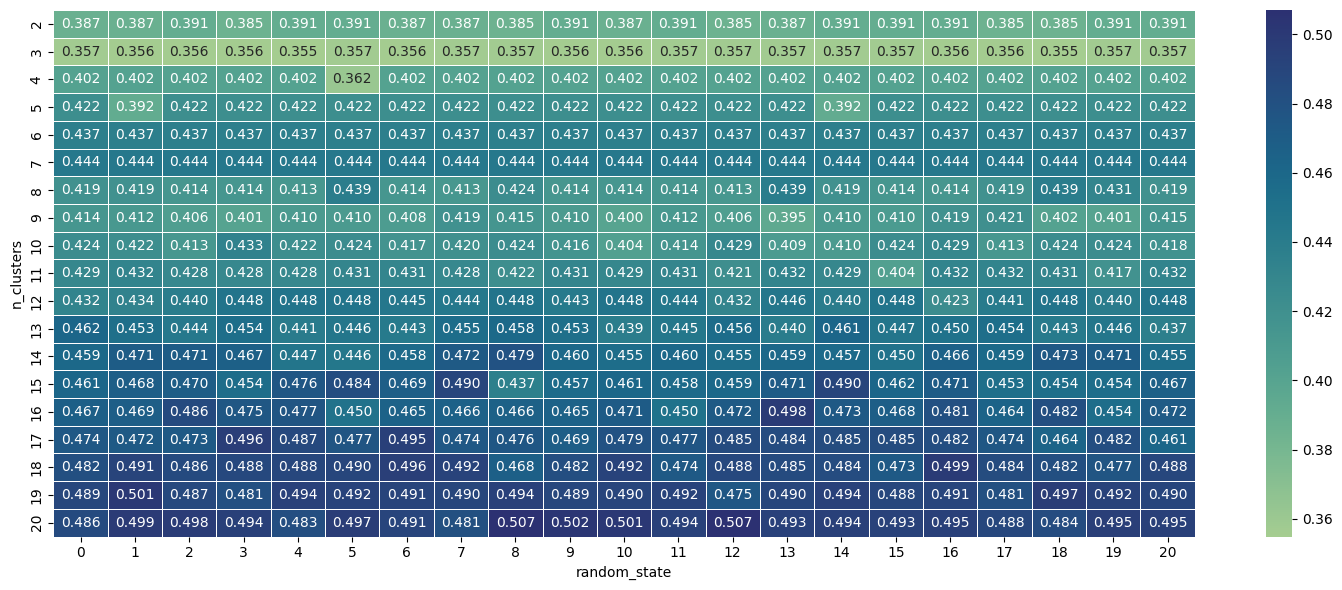

In [15]:
mm_kmeans_df = pd.DataFrame(scores_dict['MinMax-KMEANS'])

mm_kmeans_pivot = pd.pivot_table(mm_kmeans_df, index = 'n_clusters', columns = 'random_state', values = 'score')
plt.figure(figsize=(15, 6))
sns.heatmap(mm_kmeans_pivot, annot=True, fmt='.3f', linewidths=.5,  cmap='crest')
plt.tight_layout()

We observe that the silhouette score peaks around n_clusters = 6,7, decreases for intermediate values and reaches a maximum for the highest values sampled: this suggest a values of n_cluster of 6 or 7 to be the best choice. 

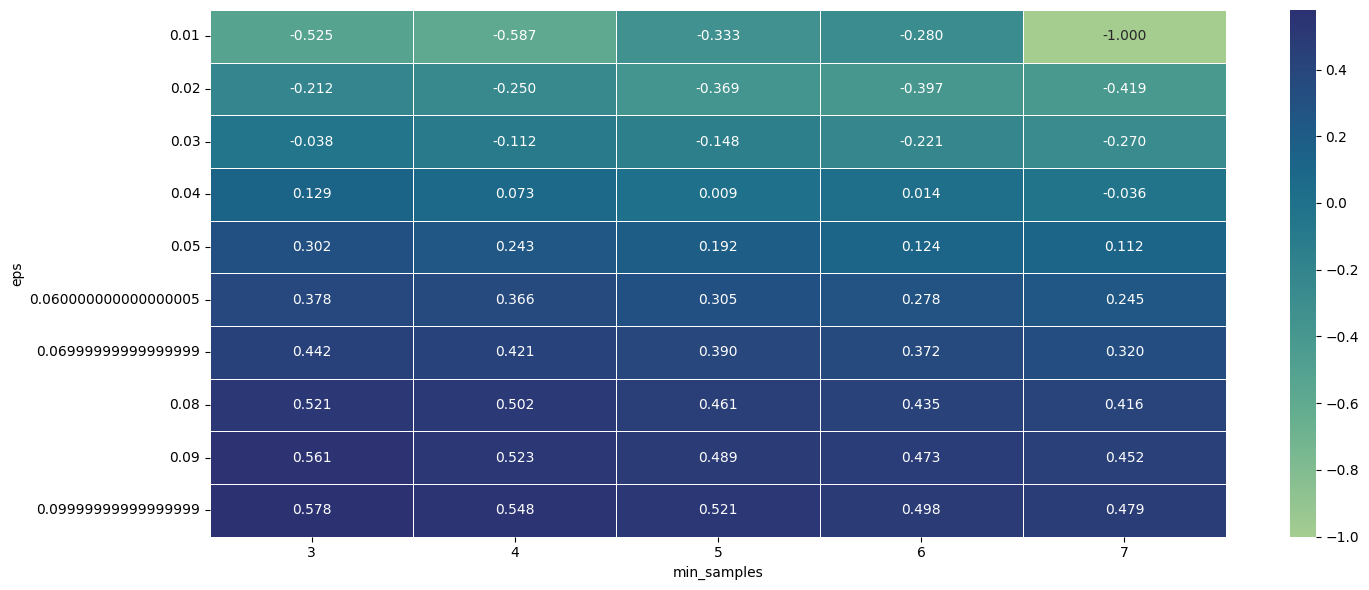

In [16]:
mm_dbscan_df = pd.DataFrame(scores_dict['MinMax-DBSCAN'])
mm_dbscan_df.head()

mm_dbscan_pivot = pd.pivot_table(mm_dbscan_df, index = 'eps', columns = 'min_samples', values = 'score')
plt.figure(figsize=(15, 6))
sns.heatmap(mm_dbscan_pivot, annot=True, fmt='.3f', linewidths=.5,  cmap='crest')
plt.tight_layout()

These results simply shows higher score are reached if we allow for lower density to define a cluster, since this could lead to a less meaningful clustering we select hyperparameters with score close to the one obtained by KMeans with n_cluster = 6, for example $\{min_{sample} = 5, eps = 0.08\}$ is just slightly better.</br>
To check if the clusters obtained are sensible we plot them in a 3D space obtained by the original dataset with Principal Components Analysis, while there is a loss of information in the dimensionality reduction procedure it would give us a sense of how the data has been divided in clusters:

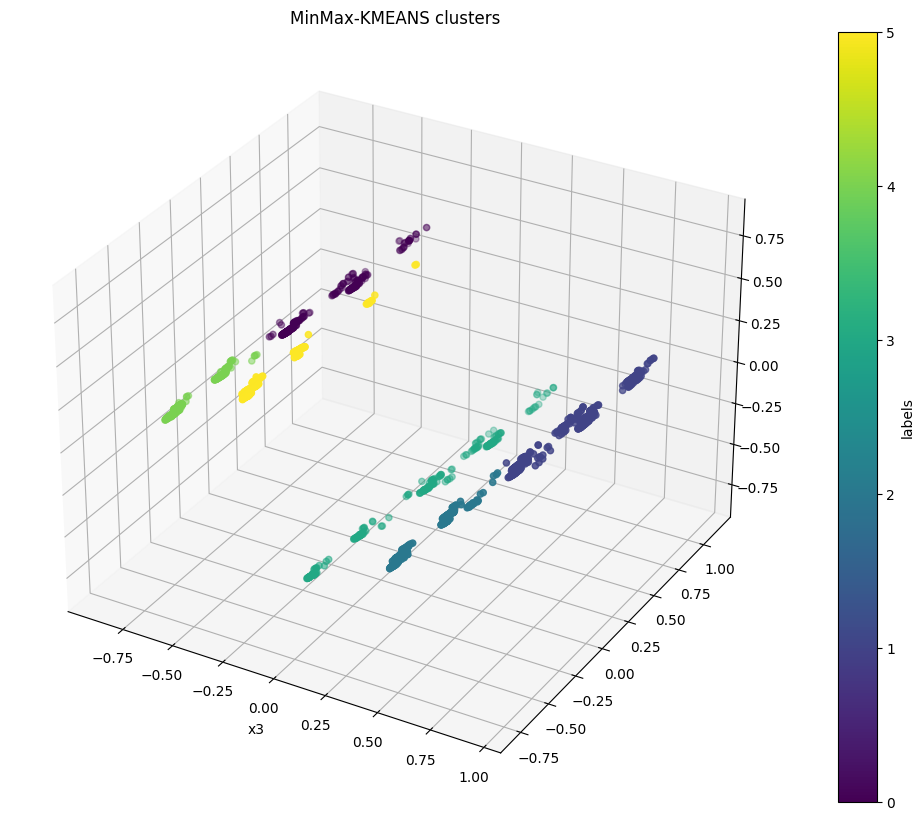

In [17]:
def plot_clusters(df, preprocessor, model, estimator = None):
    X = preprocessor.fit_transform(df) if preprocessor is not None else train
    pca = PCA(n_components = 3, random_state = 7)
    X_pca = pca.fit_transform(X)
    pca_df = pd.DataFrame(X_pca, columns = ['x1', 'x2', 'x3'])
    model.fit(X)
    pca_df['labels'] = model.labels_
    fig = plt.figure(figsize = (15,10))
    ax = fig.add_subplot(111, projection = '3d')
    scatter = ax.scatter(pca_df['x1'], pca_df['x2'], pca_df['x3'], c = pca_df['labels'], cmap = 'viridis')
    cbar = plt.colorbar(scatter)
    cbar.set_label('labels')
    ax.set_xlabel('x1')
    ax.set_xlabel('x2')
    ax.set_xlabel('x3')
    plt.title(f'{estimator} clusters')
    plt.show()
    return model.labels_

kmeans = KMeans(n_clusters = 6, random_state = 7)
kmeans_labels = plot_clusters(train, pipeline_MinMax, kmeans, 'MinMax-KMEANS')

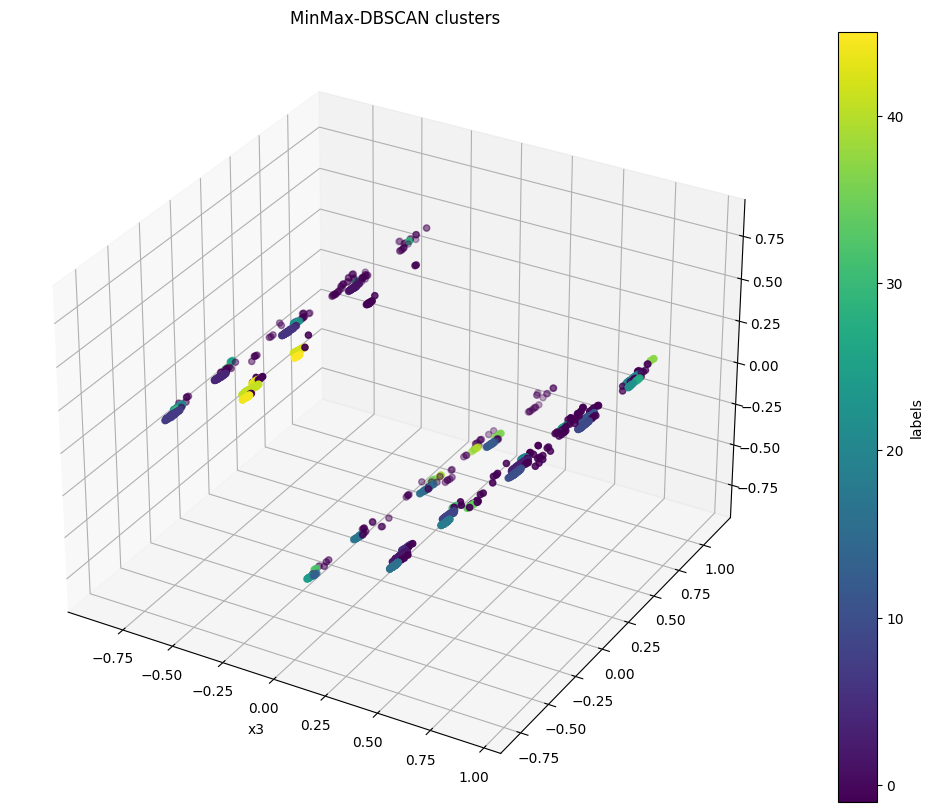

In [18]:
dbscan = DBSCAN(eps = 0.08, min_samples = 5)
dbscan_labels = plot_clusters(train, pipeline_MinMax, dbscan, 'MinMax-DBSCAN')

**Outtakes**:
While the KMeans fit results in well separated clusters, the DBSCAN produce clusters which are more sparse and not as well distinct: we therefore choose the fit with MinMax preprocessing and KMeans model with n_cluster = 6 as the optimal one.

<h2>CLUSTERS INTERPRETATION</h2>

Let's now study the main featurea of each cluster: we attach the clusters label to the original dataset and then visualize the features distribution cluster by cluster:

In [19]:
final_results_df = train.copy()
final_results_df['Cluster'] = kmeans_labels
final_results_df['Sex'] = final_results_df['Sex'].apply(lambda x : Sex_dict.get(x, 'Other'))
final_results_df['Marital status'] = final_results_df['Marital status'].apply(lambda x : Marital_Status_dict.get(x, 'Other'))
final_results_df['Education'] = final_results_df['Education'].apply(lambda x : Education_dict.get(x, 'Other'))
final_results_df['Occupation'] = final_results_df['Occupation'].apply(lambda x : Occupation_dict.get(x, 'Other'))
final_results_df['Settlement size'] = final_results_df['Settlement size'].apply(lambda x : Settlement_Size_dict.get(x, 'Other'))
final_results_df.head()

,Sex,Marital status,Age,Education,Income,Occupation,Settlement size,Cluster
ID,,,,,,,,
100000001,Male,Single,67,Uni,124670,Skilled,Big,1
100000002,Female,Non-Single,22,High school,150773,Skilled,Big,0
100000003,Male,Single,49,High school,89210,no/Unskilled,Small,2
100000004,Male,Single,45,High school,171565,Skilled,Mid,1
100000005,Male,Single,53,High school,149031,Skilled,Mid,1


In [20]:
def summary_plots(df, cat_feats, num_feats):
    summary = f'CLUSTER SIZE: {len(df)}\n'
    n_rows = int(np.ceil(len(cat_feats + num_feats) / 3.))
    _, axes = plt.subplots(n_rows, 3, figsize = (15, 10))
    for feat, ax in zip(cat_feats + num_feats, axes.ravel()):
        if feat in cat_feats:
            sns.countplot(data = df, x = feat, ax = ax)
            ax.set_title(feat)
            summary += f'{feat} mode: {df[feat].mode()[0]}\n'
        else:
            sns.histplot(data = df, x = feat, bins = 50, kde = True, ax = ax)
            ax.set_title(feat)
            summary += f'{feat} median: {df[feat].median()}\n'
    plt.tight_layout()
    plt.show()
    print(summary)

<h3>Cluster 0</h3>

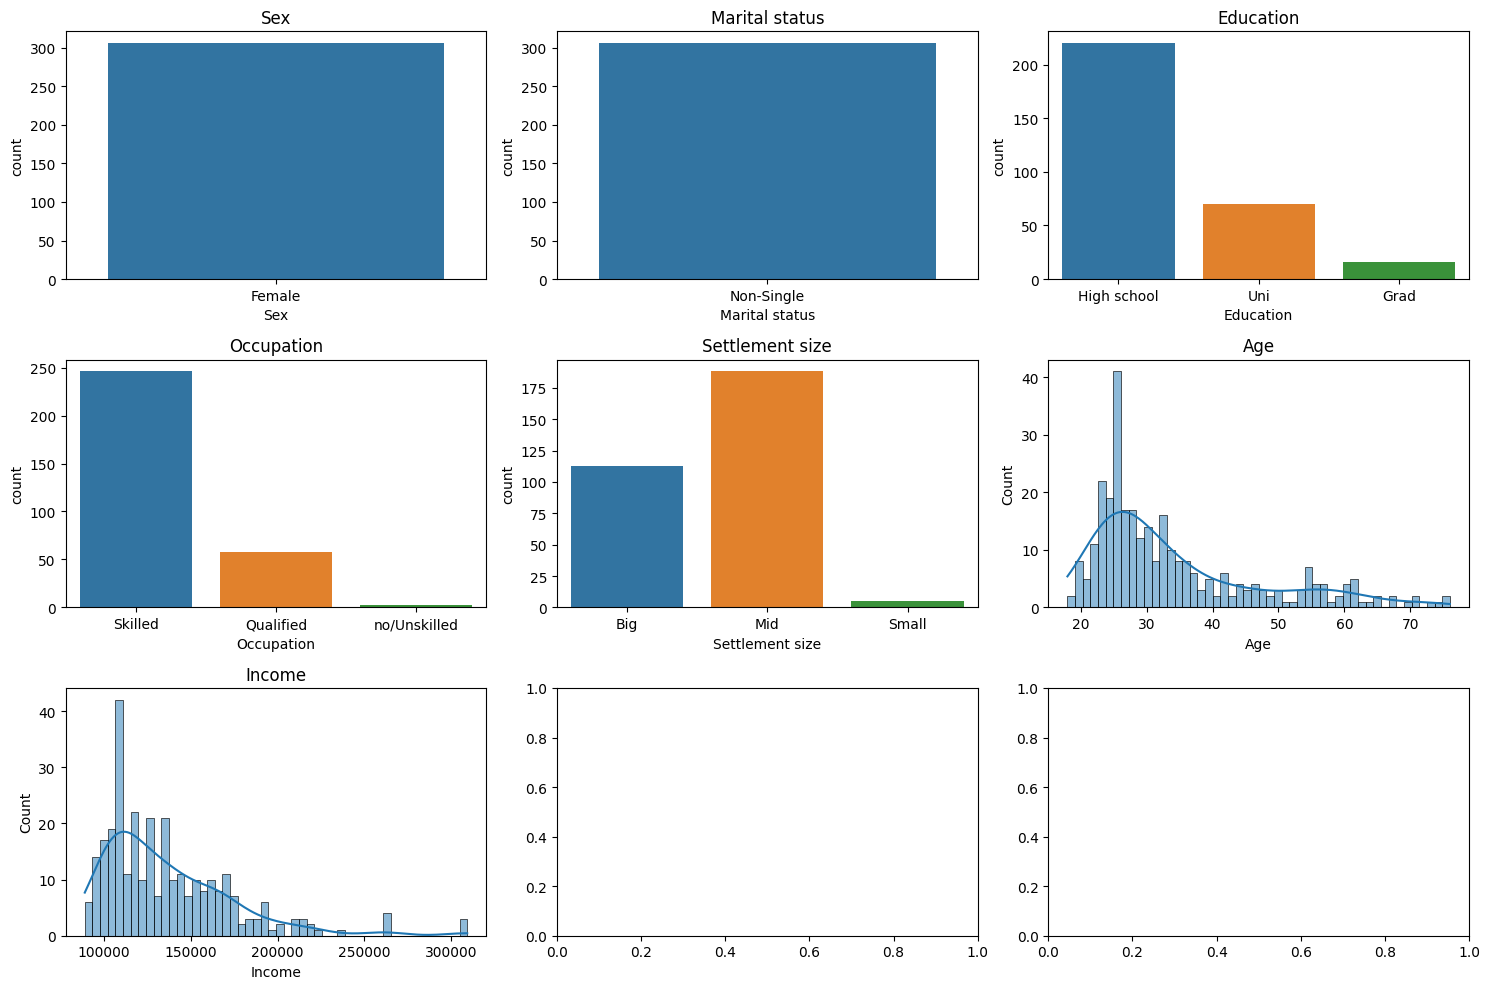

CLUSTER SIZE: 306
Sex mode: Female
Marital status mode: Non-Single
Education mode: High school
Occupation mode: Skilled
Settlement size mode: Mid
Age median: 29.0
Income median: 126778.5



In [21]:
final_results_0 = final_results_df[final_results_df['Cluster'] == 0]
summary_plots(final_results_0, categorical_feats, numerical_feats)

The cluster is composed by non-single women, with mostly an high school education and skilled jobs (with a minor fraction of college graduete and qualified jobs) living in mid-sized or big cities, tipically in their twenties/mid thirties and with median income of 130000.

<h3>Cluster 1</h3>

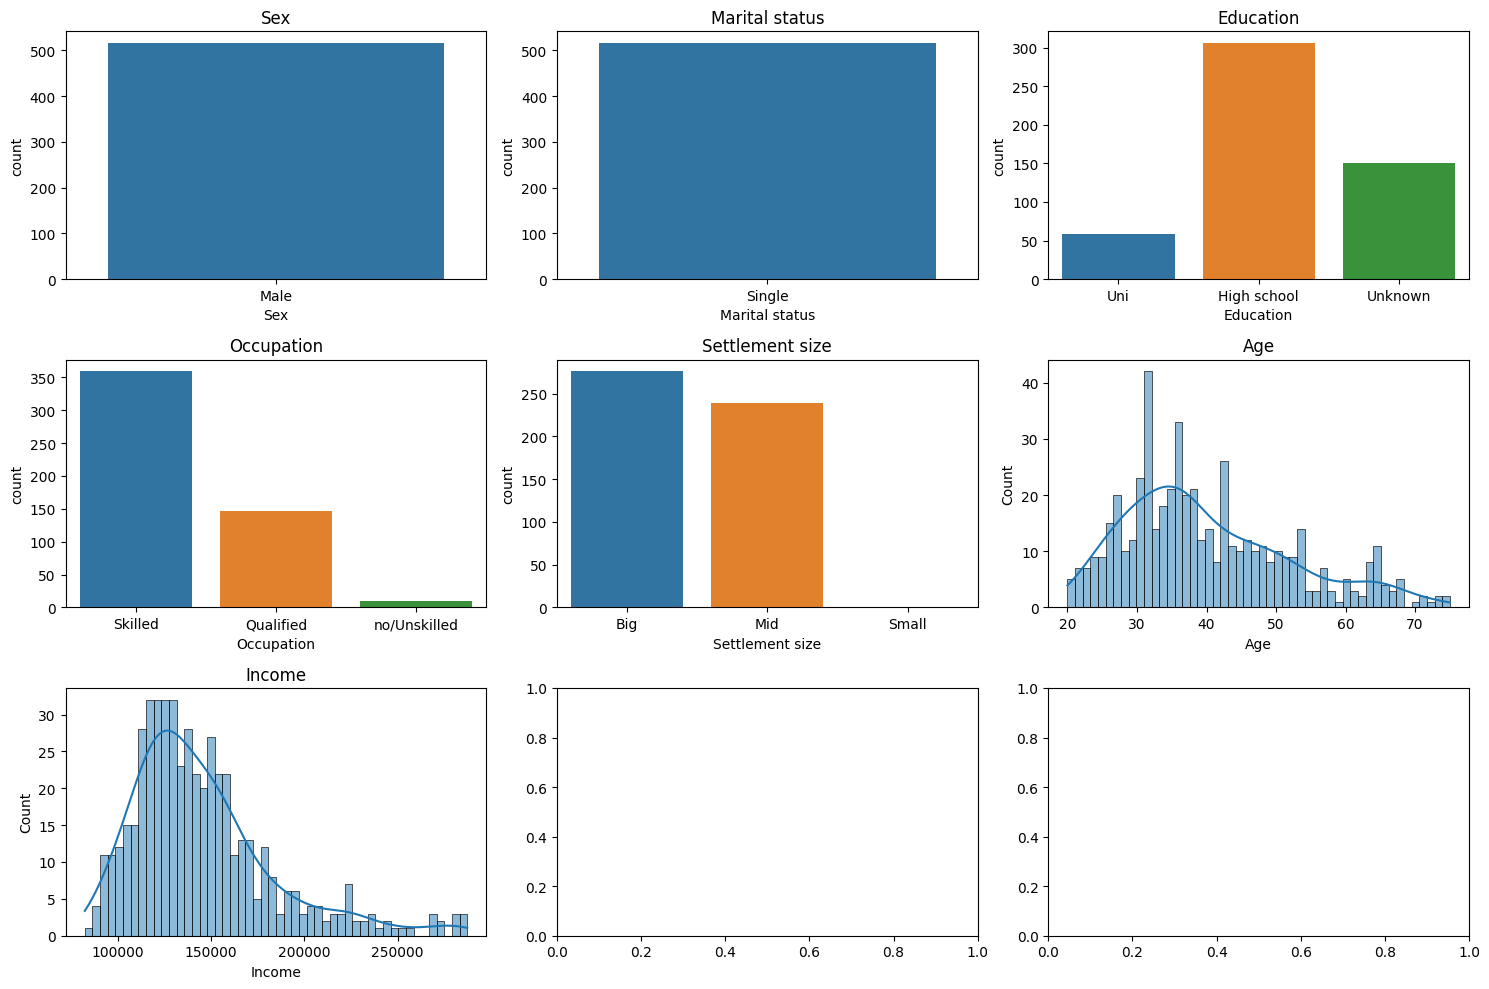

CLUSTER SIZE: 516
Sex mode: Male
Marital status mode: Single
Education mode: High school
Occupation mode: Skilled
Settlement size mode: Big
Age median: 37.0
Income median: 136317.5



In [22]:
final_results_1 = final_results_df[final_results_df['Cluster'] == 1]
summary_plots(final_results_1, categorical_feats, numerical_feats)

This cluster is composed of single males, mostly with high school or unknown education, with skilled or qualified jobs, not living in small cities, with a median income of 136000. 

<h3>Cluster 2</h3>

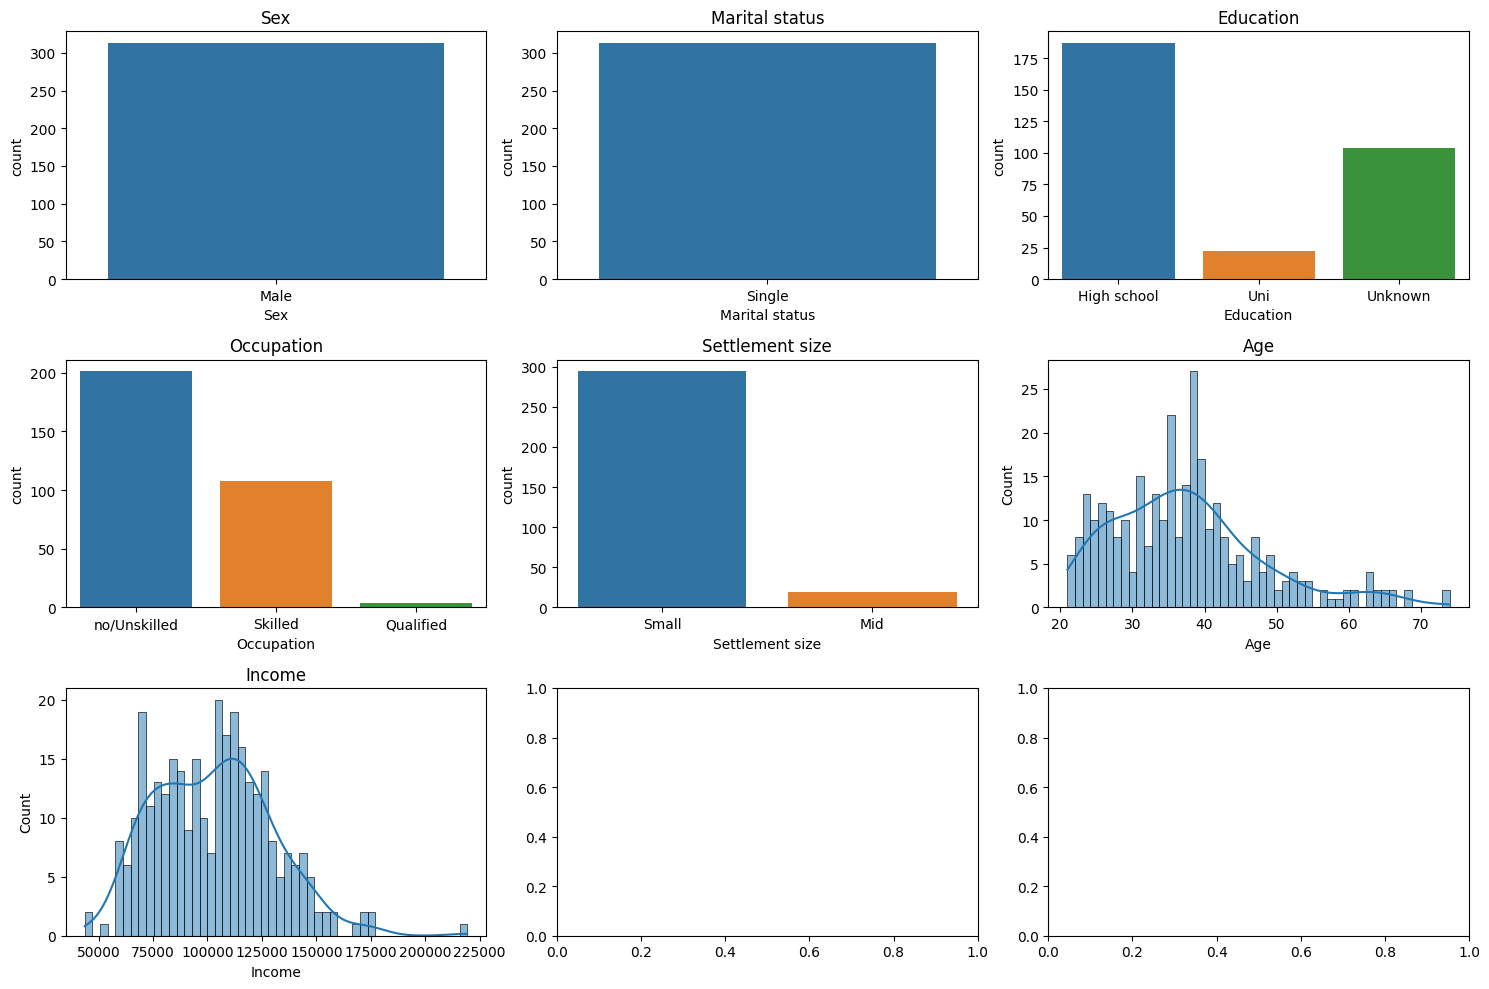

CLUSTER SIZE: 313
Sex mode: Male
Marital status mode: Single
Education mode: High school
Occupation mode: no/Unskilled
Settlement size mode: Small
Age median: 36.0
Income median: 103716.0



In [23]:
final_results_2 = final_results_df[final_results_df['Cluster'] == 2]
summary_plots(final_results_2, categorical_feats, numerical_feats)

This cluster is composed by single males, mostly of unknown or high school education, unemployed or with lower skill jobs, mostly between their thirties and mid-forties with a median income of around 104000.

<h3>Cluster 3</h3>

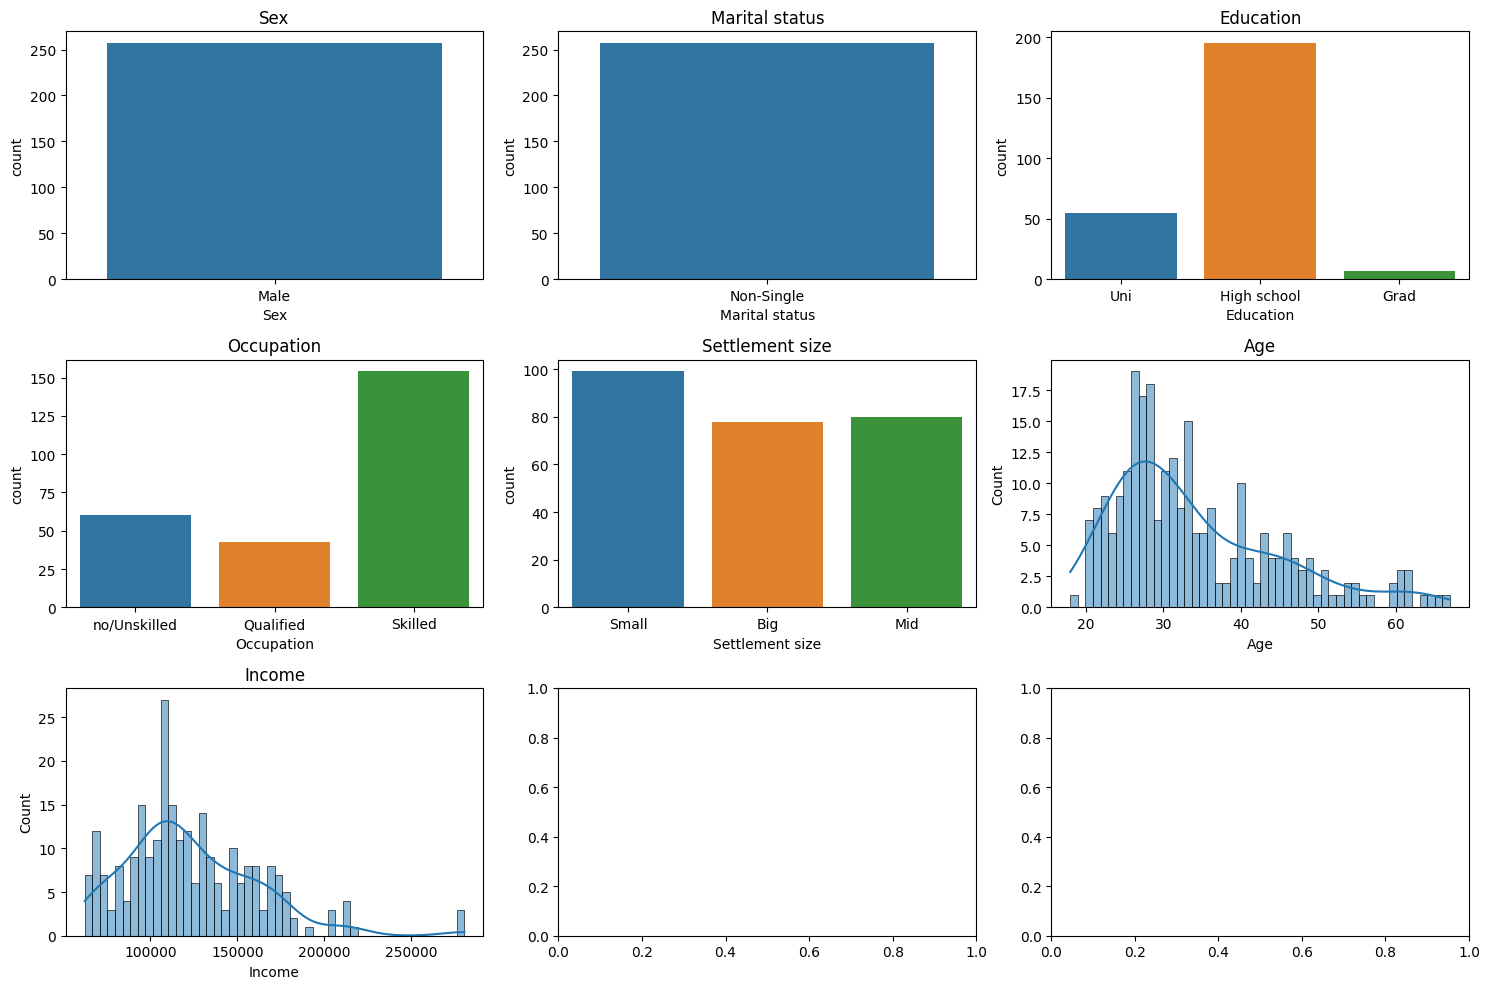

CLUSTER SIZE: 257
Sex mode: Male
Marital status mode: Non-Single
Education mode: High school
Occupation mode: Skilled
Settlement size mode: Small
Age median: 31.0
Income median: 115369.0



In [24]:
final_results_3 = final_results_df[final_results_df['Cluster'] == 3]
summary_plots(final_results_3, categorical_feats, numerical_feats)

This cluster is composed by non-single males, motly with high school education with a minor fraction of college graduates, mostly employed, in their twenties or thirties with a median income around 11500 and spread pretty evenly between small, mid and big cities.

<h3>Cluster 4</h3>

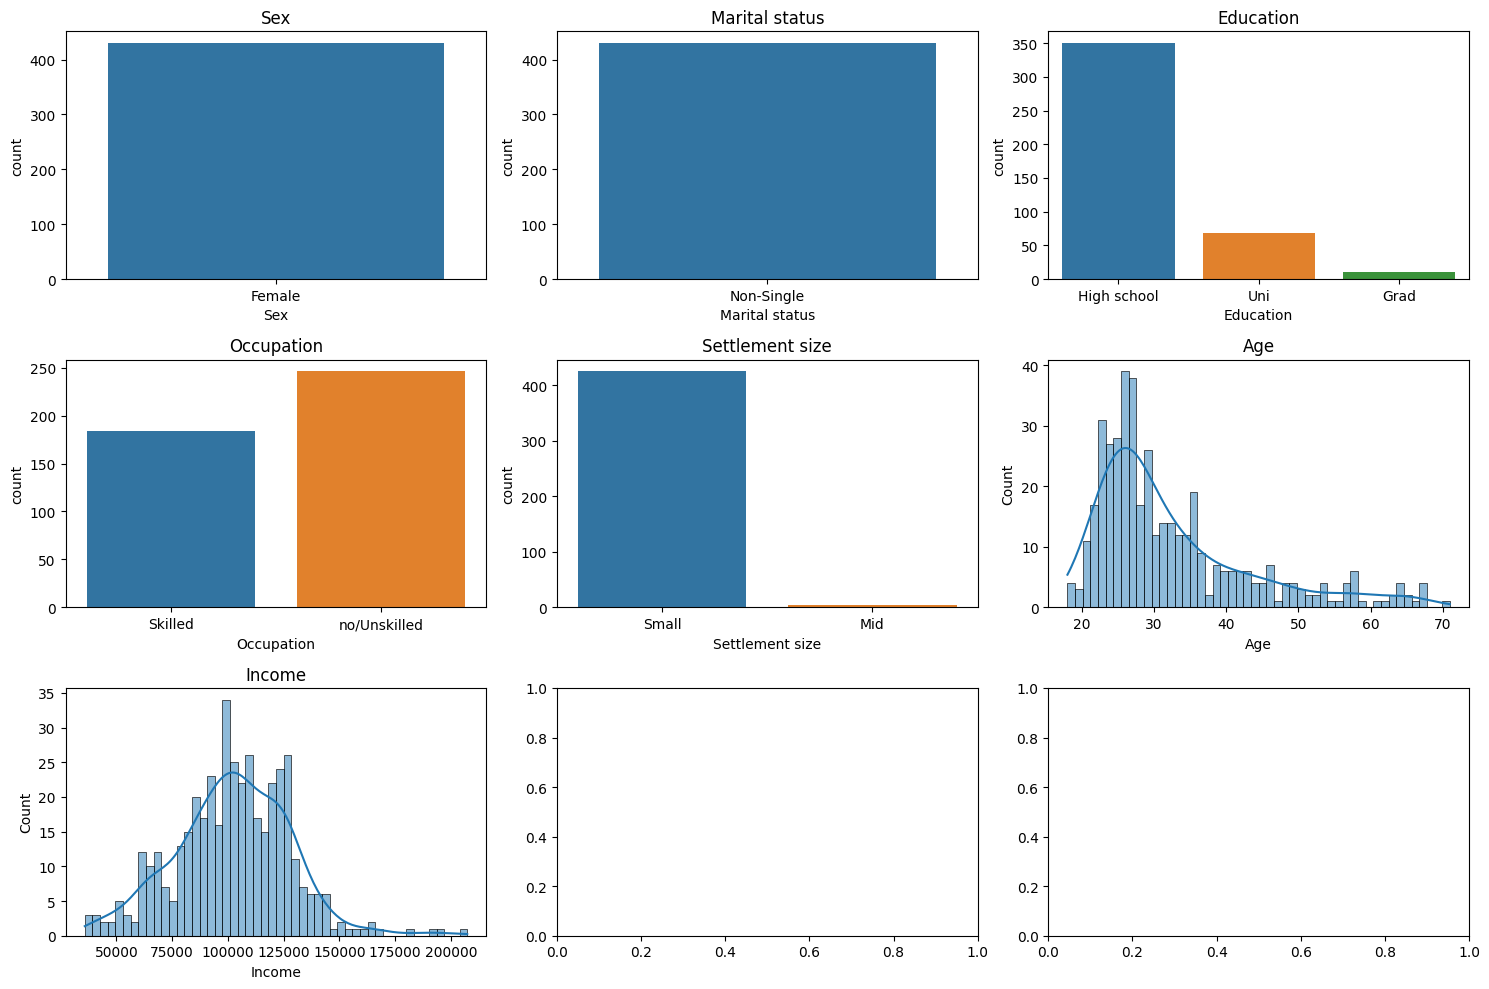

CLUSTER SIZE: 430
Sex mode: Female
Marital status mode: Non-Single
Education mode: High school
Occupation mode: no/Unskilled
Settlement size mode: Small
Age median: 28.5
Income median: 102323.5



In [25]:
final_results_4 = final_results_df[final_results_df['Cluster'] == 4]
summary_plots(final_results_4, categorical_feats, numerical_feats)

This cluster is composed of non-single females,mostly with high school education with a minor fraction of college graduate, unemployed of with lower skilled jobs with similar proportions, almost always in small cities, tipycally in their twenties or thirties with a median income around 102000.

<h3>Cluster 5</h3>

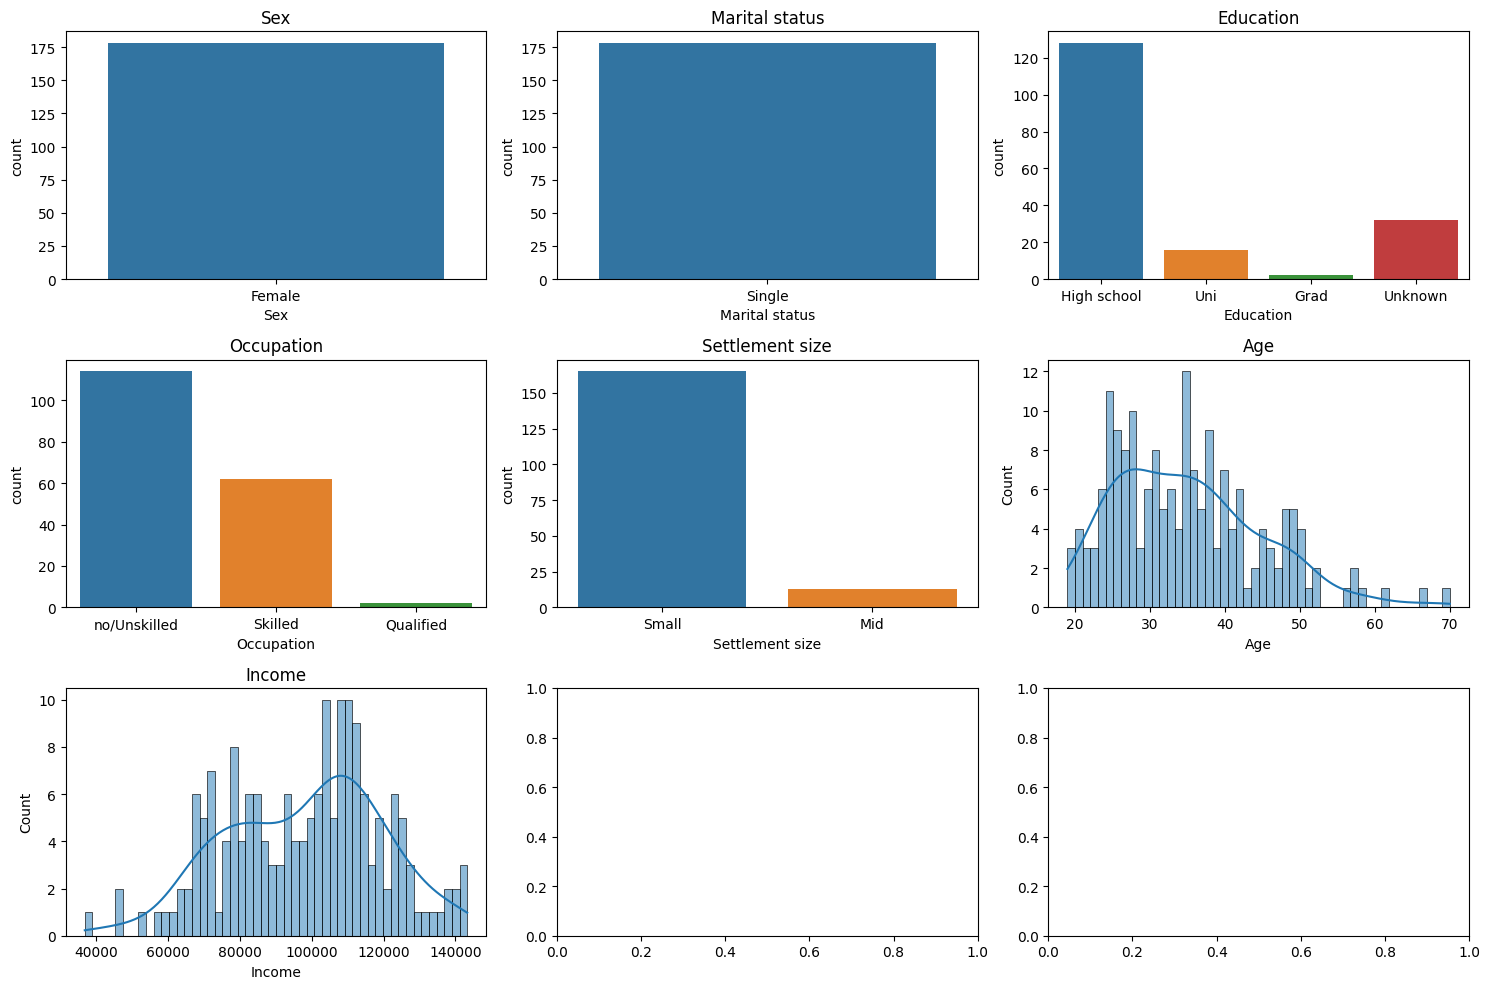

CLUSTER SIZE: 178
Sex mode: Female
Marital status mode: Single
Education mode: High school
Occupation mode: no/Unskilled
Settlement size mode: Small
Age median: 34.5
Income median: 101511.0



In [26]:
final_results_5 = final_results_df[final_results_df['Cluster'] == 5]
summary_plots(final_results_5, categorical_feats, numerical_feats)

This cluster is composed by single females, mostly with high school education, unemployed or with lower skill jobs, usually in small cities and in their thirties, their median income is around 102000 with an upper limit of 140000.